# Exchange Rate Futures
## In-sample: 2014-2016   validation: 2017
## Pair Trading:

### This project is to extract potential opportunities of pair trading for varies futures.

### Data is based on minute prices from Quantopian. This Python code is for Quantopian.

### Steps:
##### 1. Compute sample correlation of in-sample future returns.

##### 2. Compute and plot simple price spreads of any two futures for further observations.

For example, for futures X and Y,
if series of (X's returns - Y's retuns) looks like a stable series, then this implies that it is possible for us to generate stable returns by going long a share of X and going short a share of Y.

##### 3. Compute and plot division price spreads of any two futures for further observations.

##### 4. Find pairs with significant (p-value < 0.05) co-integration.

##### 5. If future X and future Y has a significant in-sample co-integration, apply OLS regression model to get coefficients between X's returns and Y's returns during in-sample periods.

For example, in-sample period is 2014-2015. Then, get coefficient and intercept between X's returns and Y's returns in 2014-2016, such as (Y'sreturn = 0.1 + 0.5 * X's return).

##### 6. Compute, plot and check residules in validation period.

For example, for future X and future Y, compute residules as (Y's return - 0.1 - 0.5 * X's return) in validation period, 2017.

If the residules look like stable series, this further confirms that we may make use of the pair relationships to form a pair trading strategy.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from quantopian.research.experimental import continuous_future, history
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import adfuller
import seaborn as sns

In [3]:
 Rates = {
    'rates': {
        'us_2y': continuous_future('TU'),
        'us_30y': continuous_future('US'),
        'deliverable_interest_rate_swap_5y': continuous_future('FI'),
        'deliverable_interest_rate_swap_10y': continuous_future('TN'),
        'utra_tbond': continuous_future('UB'),
        'fed30day': continuous_future('FF'),
        'eur': continuous_future('ED'),
        'eurodollar_nyse_liffe': continuous_future('EL'),
    }}

In [4]:
# Get data of different futures
def get_data(future_dic,start_date, end_date,fields_type='price',frequency_type='minute'):
    df = pd.DataFrame()
    future_list = future_dic.values()[0]
    for future_name, future_data in future_list.items():

        data = history(future_data, start = start_date, end = end_date, fields = fields_type, frequency = frequency_type)
        data = pd.DataFrame(data)
        data.columns=[future_name+'_'+'_'+frequency_type]
        df = pd.concat([df,data],axis=1)
    return df

# Calculate simple price spread
def spread_subtraction(df,times=1):
    future_name = df.columns

    delta_df = pd.DataFrame()

    for i in range(len(future_name)):
        for j in range(i+1,len(future_name)):
            y_future = future_name[i]
            x_future = future_name[j]

            delta_df[y_future+' - '+x_future] = df[y_future] - times*df[x_future]
    
    return delta_df


# Calculate price division 
def spread_division(df):
    future_name = df.columns
    delta_df = pd.DataFrame()

    for i in range(len(future_name)):
        for j in range(i+1,len(future_name)):
            y_future = future_name[i]
            x_future = future_name[j]

            delta_df[y_future+' / '+x_future] = df[y_future] / df[x_future]
    
    return delta_df


# Plot time series
def plotting(df):
    future_name = df.columns
    num = len(future_name)

    for i in future_name:
        plt.figure(figsize=(10,3))
        plt.plot(df[i])
        plt.title(i)
        plt.show()
    
# Get adf test results to determine whether time series is stationary
def adf_test(df):
    future_name = df.columns
    adf_df = pd.DataFrame()

    for i in future_name:
        adftest = adfuller(df[i])
        adf_df.ix[i,'Test Statistic'] = adf_test[0]
        adf_df.ix[i,'p-value'] = adf_test[1]
        adf_df.ix[i,'Test Statistic'] = adf_test[0]

        for key, value in adftest[4].items():
            adf_df[i,'Critical Value (%s)'% key] = value
        
    return adf_test


# Find paris with significant cointegration
def find_cointegrated_paris(df,pvalue_level=0.05):
    future_name = df.columns
    n = len(future_name)
    pvalue_matrix = np.ones((n,n))

    pairs = []

    for i in range(len(future_name)):
        for j in range(i+1,len(future_name)):
            y_future = future_name[i]
            x_future = future_name[j]

            result = ts.coint(df[y_future],df[x_future])

            pvalue = result[1]
            pvalue_matrix[i,j] = pvalue

            if pvalue < pvalue_level:
                pairs.append((y_future,x_future))
    return pvalue_matrix, pairs

# Get ols parameters
def ols_in_sample(df,pairs):
    future_name = df.columns
    ols_df = pd.DataFrame()

    for i in range(len(future_name)):
        for j in range(i+1,len(future_name)):
            y_future = future_name[i]
            x_future = future_name[j]

            if (y_future,x_future) in pairs:
                reg = sm.add_constant(df[x_future])
                results = sm.OLS(df[y_future], reg).fit()
                
                name = str(y_future+' vs '+x_future)

                ols_df.loc[name,'cons'] = results.params[0]
                ols_df.loc[name,'coef'] = results.params[1]
            
    return ols_df

# Get residules of validation data based on in-sample ols parameters
def ols_validation(df, ols_df,pairs):
    future_name = df.columns
    ols_validation_df = pd.DataFrame()
    for i in range(len(future_name)):
        for j in range(i+1,len(future_name)):
            y_future = future_name[i]
            x_future = future_name[j]

            if (y_future,x_future) in pairs:
                name = str(y_future+' vs '+x_future)
                
                cons = ols_df.loc[name,'cons'] 
                coef = ols_df.loc[name,'coef']
                ols_validation_df[y_future+' vs '+x_future+' _residules'] = df[y_future] - cons - coef*df[x_future]
            
    return ols_validation_df

# 2. In-sample Period: 2014-2016     Validation Period: 2017

In [5]:
future_list = Rates.values()[0].keys()

In [6]:
data = get_data(Rates,'2014-01-01','2016-12-31')

### 2.1 Correlation: 2014-01-01 to 2016-12-31

In [6]:
correlation =data.corr()
correlation

,utra_tbond__minute,eurodollar_nyse_liffe__minute,us_2y__minute,deliverable_interest_rate_swap_10y__minute,fed30day__minute,deliverable_interest_rate_swap_5y__minute,us_30y__minute,eur__minute
utra_tbond__minute,1.000000,-0.676610,0.864758,0.955583,0.581291,0.912840,0.990004,0.725030
eurodollar_nyse_liffe__minute,-0.676610,1.000000,-0.177020,-0.333847,0.061464,-0.302470,-0.736797,-0.006890
us_2y__minute,0.864758,-0.177020,1.000000,0.937689,0.724263,0.954603,0.866327,0.916891
deliverable_interest_rate_swap_10y__minute,0.955583,-0.333847,0.937689,1.000000,0.762283,0.989380,0.970003,0.864614
fed30day__minute,0.581291,0.061464,0.724263,0.762283,1.000000,0.801550,0.647710,0.848326
deliverable_interest_rate_swap_5y__minute,0.912840,-0.302470,0.954603,0.989380,0.801550,1.000000,0.937466,0.911112
us_30y__minute,0.990004,-0.736797,0.866327,0.970003,0.647710,0.937466,1.000000,0.765449
eur__minute,0.725030,-0.006890,0.916891,0.864614,0.848326,0.911112,0.765449,1.000000


### Heatmap of correlation: Red → High correlation

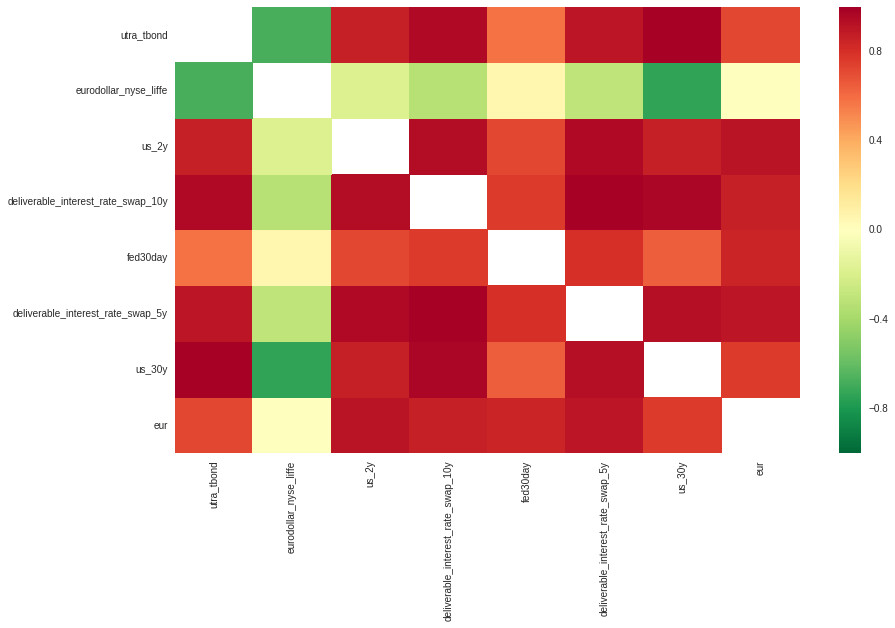

In [7]:
sns.heatmap(correlation,xticklabels=future_list, yticklabels=future_list,cmap = 'RdYlGn_r',mask=(correlation==1))

### 2.2 Price Speard

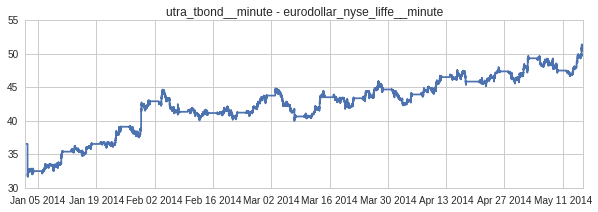

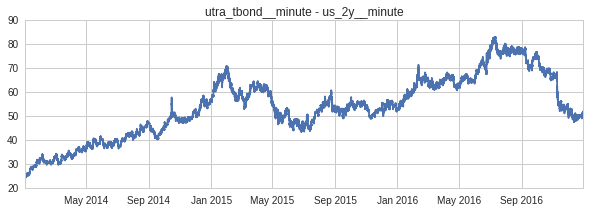

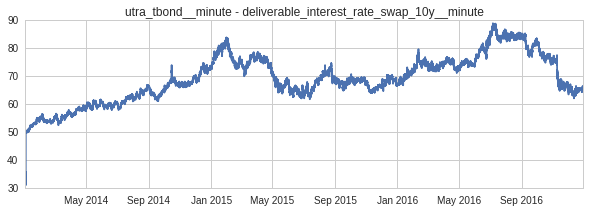

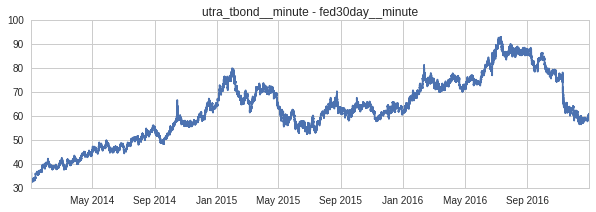

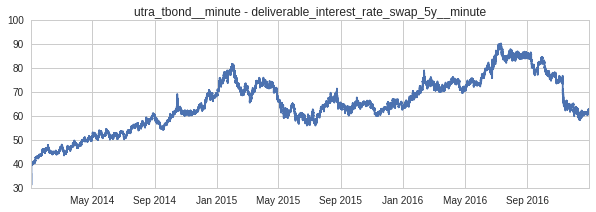

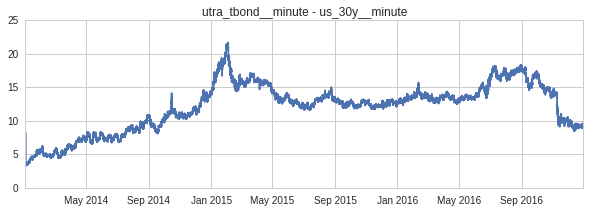

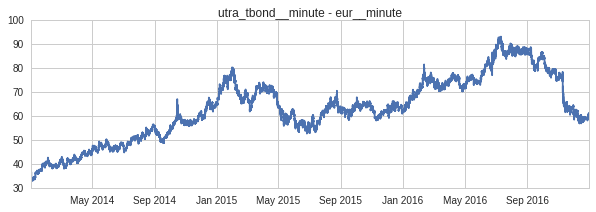

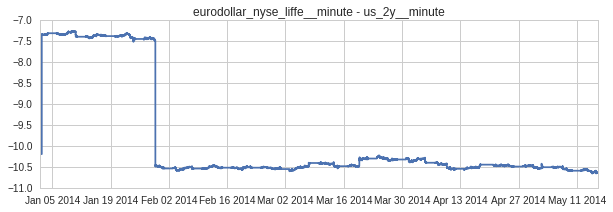

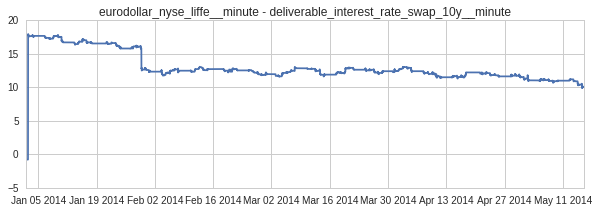

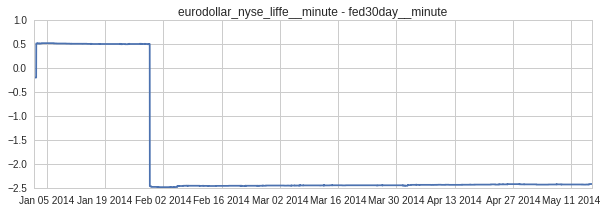

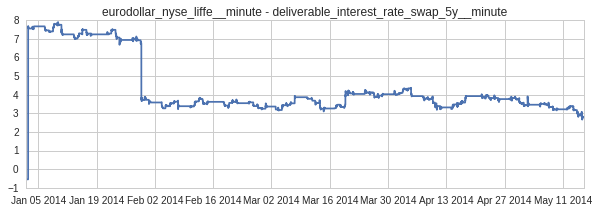

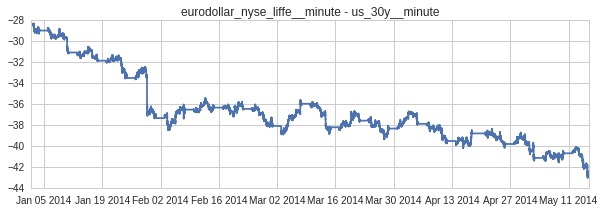

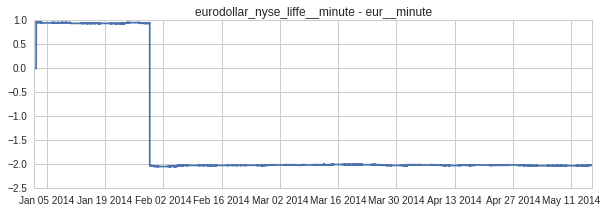

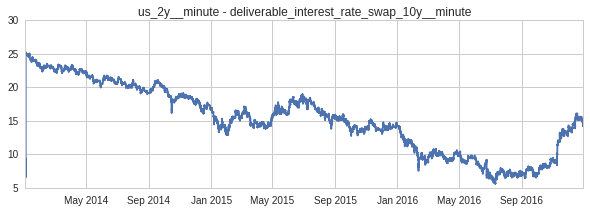

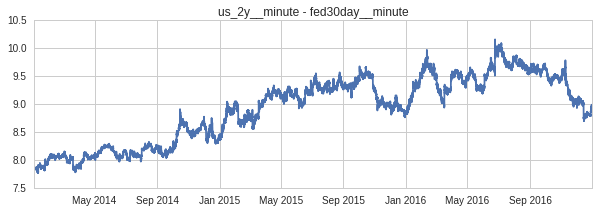

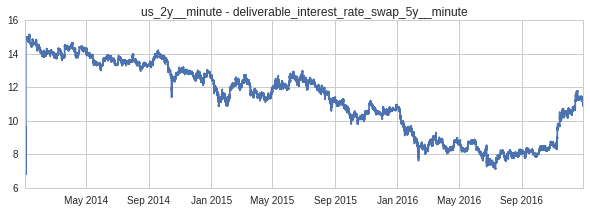

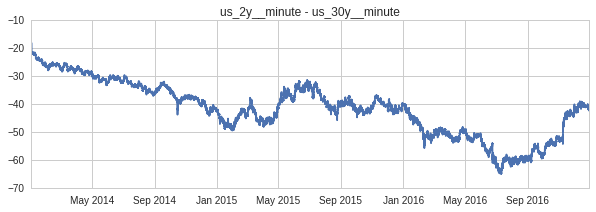

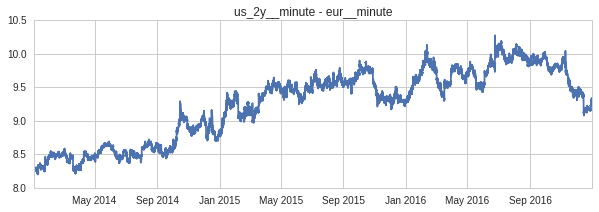

In [ ]:
a = spread_subtraction(data)
plotting(a)

### 2.3 Price Division

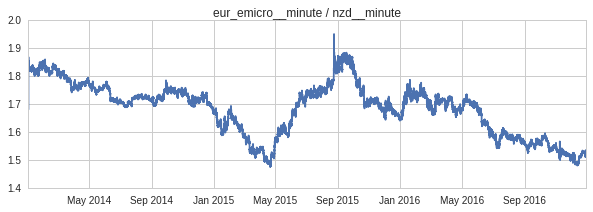

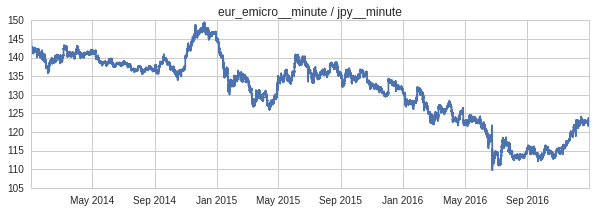

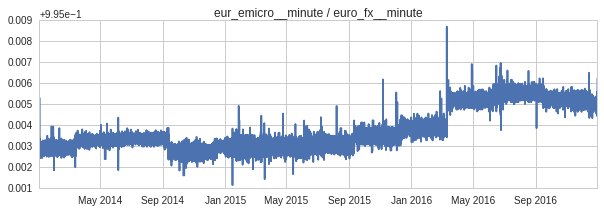

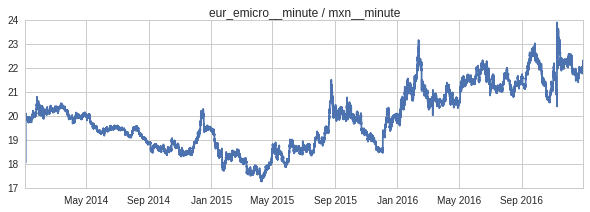

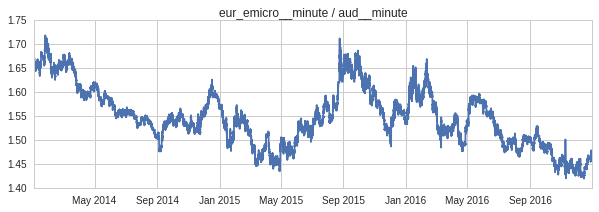

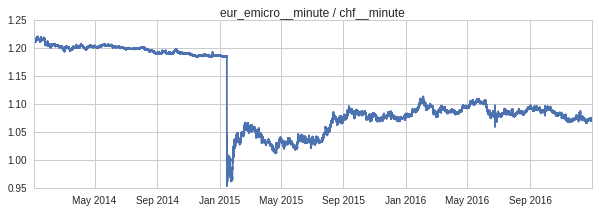

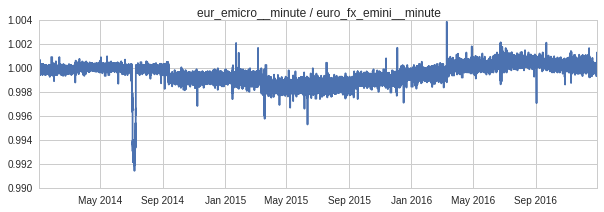

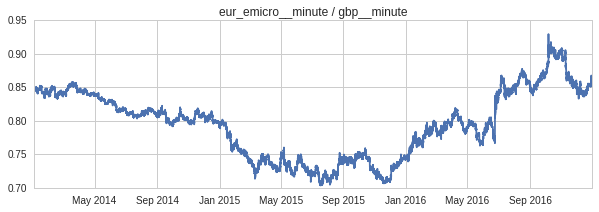

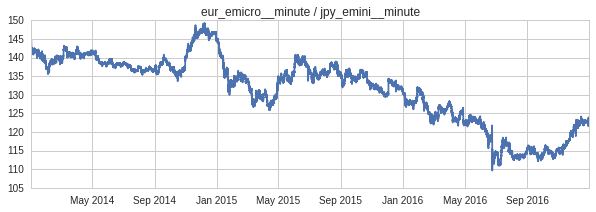

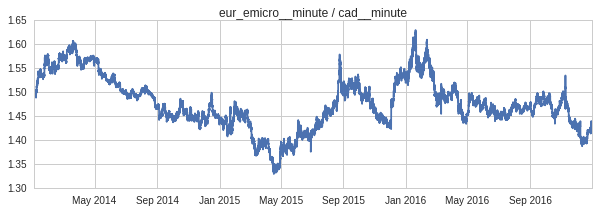

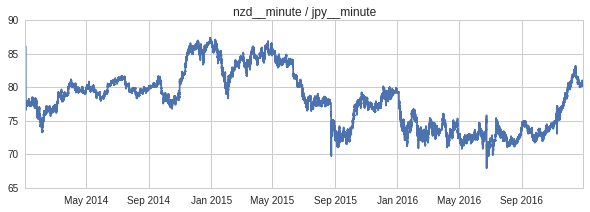

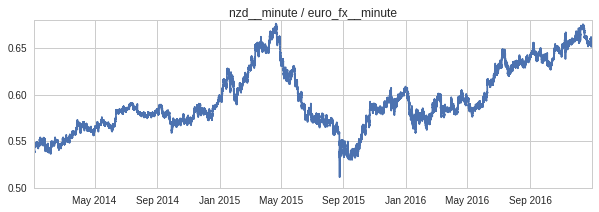

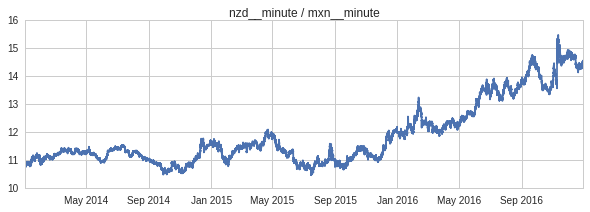

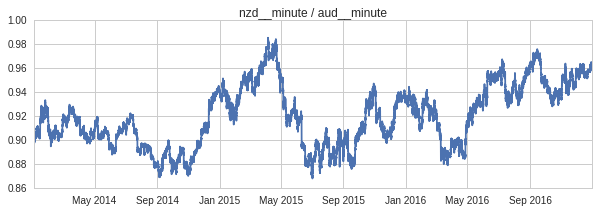

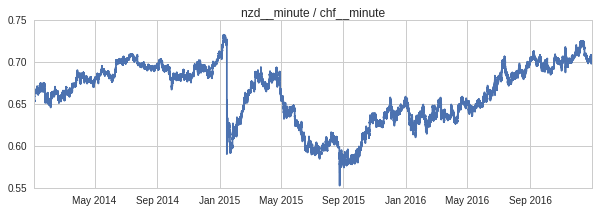

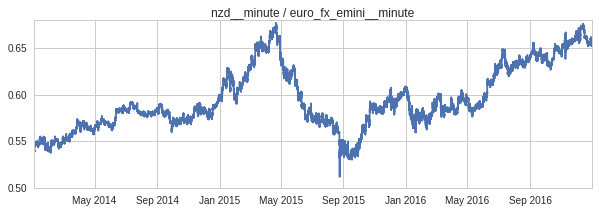

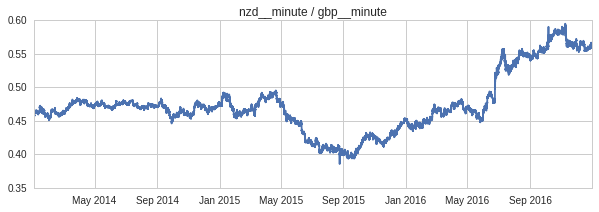

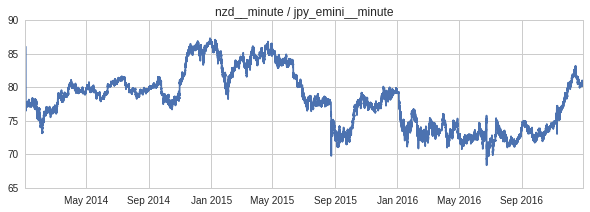

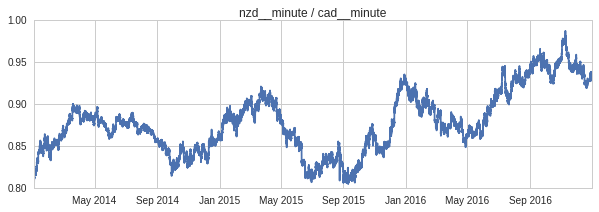

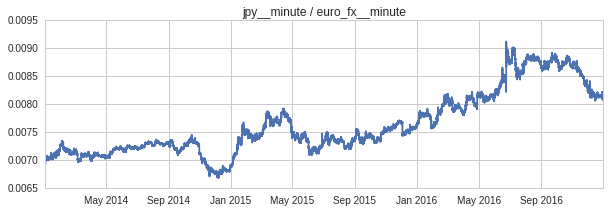

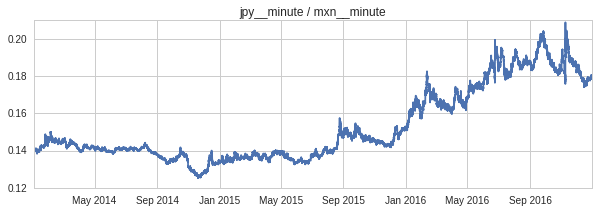

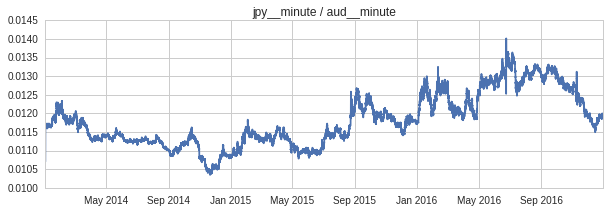

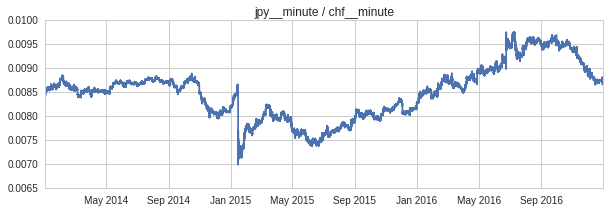

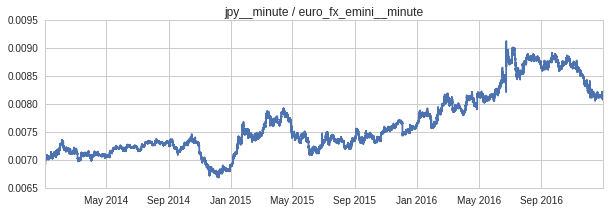

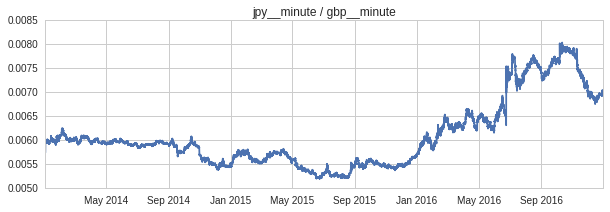

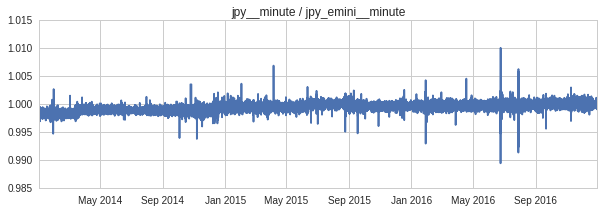

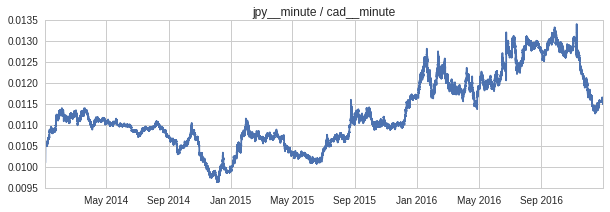

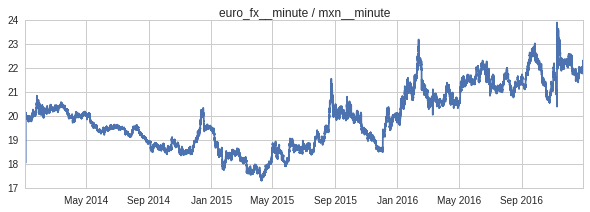

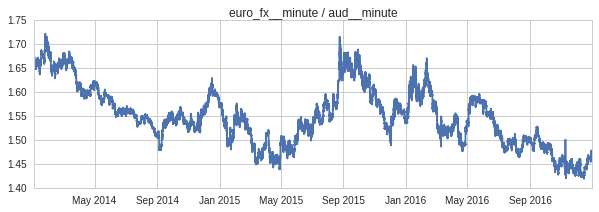

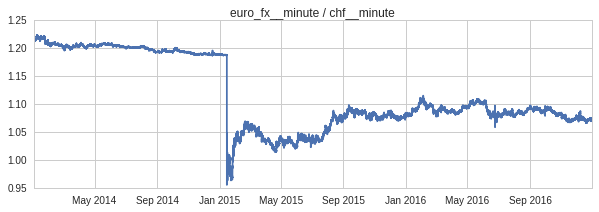

In [ ]:
b = spread_division(data)
plotting(b)

### 2.4 Cointegration  ( Green color squares imply lowest p-value and significant cointegration)

In [7]:
pvalues, pairs =  find_cointegrated_paris(data)

### Heatmap of cointegration: Green → Significant cointegration 

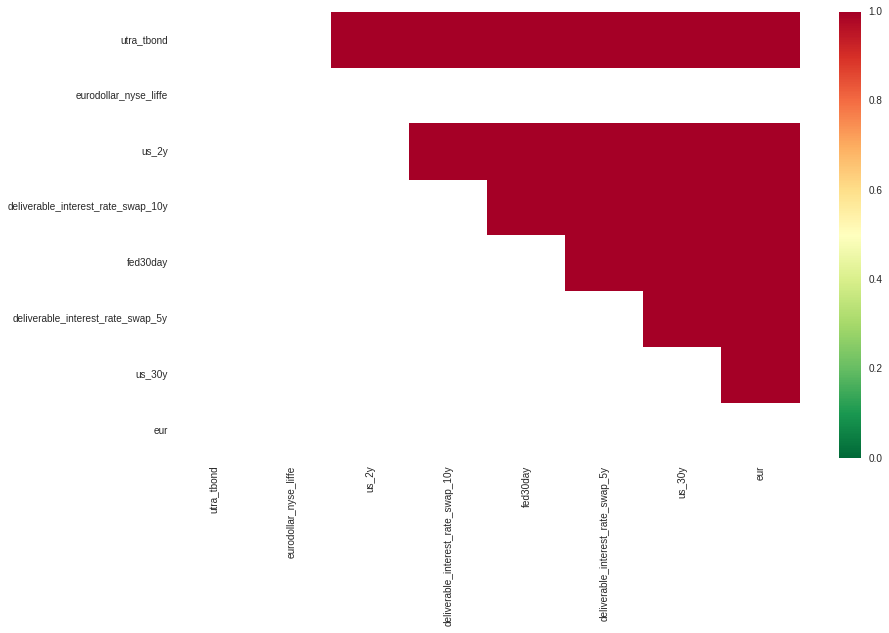

In [8]:
sns.heatmap(1-pvalues,xticklabels=future_list, yticklabels=future_list,cmap = 'RdYlGn_r',mask=(pvalues==1))

### 2.5 Pairs with significant cointegration

In [9]:
pd.DataFrame(pairs)

,0,1
0,utra_tbond__minute,us_2y__minute
1,utra_tbond__minute,deliverable_interest_rate_swap_10y__minute
2,utra_tbond__minute,fed30day__minute
3,utra_tbond__minute,deliverable_interest_rate_swap_5y__minute
4,utra_tbond__minute,us_30y__minute
5,utra_tbond__minute,eur__minute
6,us_2y__minute,deliverable_interest_rate_swap_10y__minute
7,us_2y__minute,fed30day__minute
8,us_2y__minute,deliverable_interest_rate_swap_5y__minute
9,us_2y__minute,us_30y__minute


### 2.6 OLS In-sample: 2014-2016, Validation:2017  
### (Only pairs with significant cointegration are included)

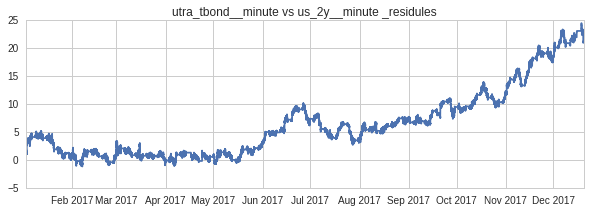

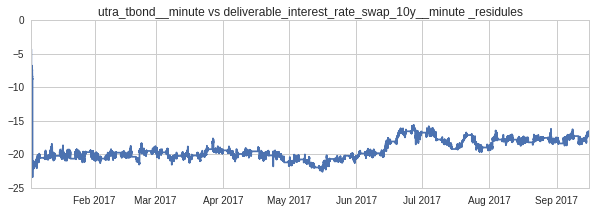

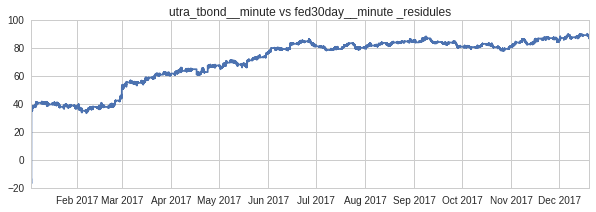

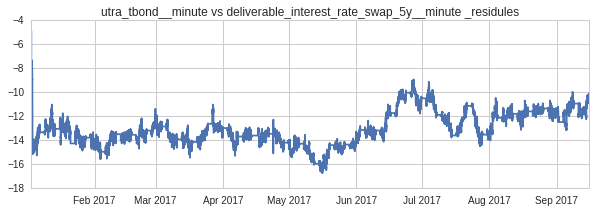

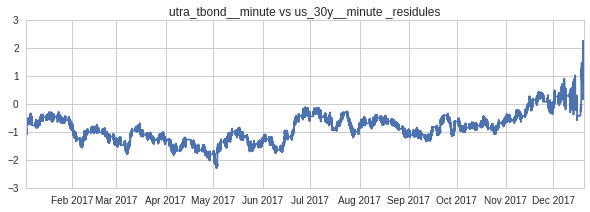

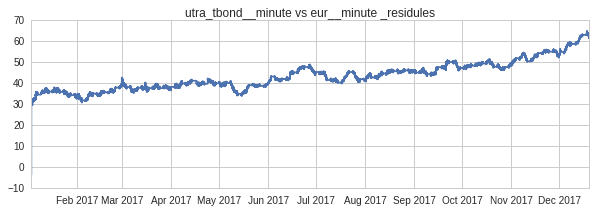

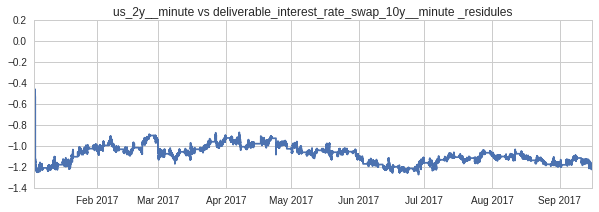

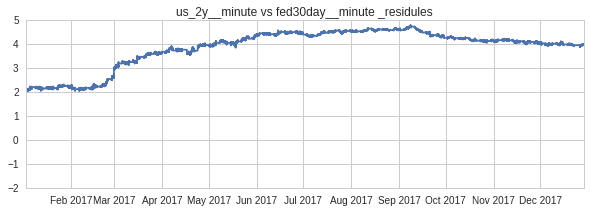

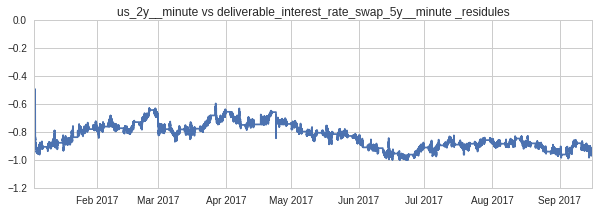

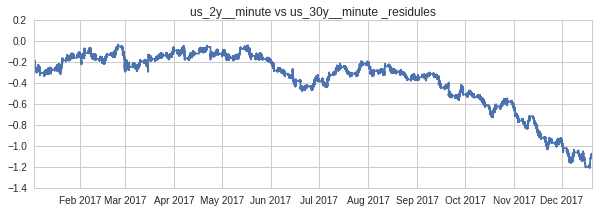

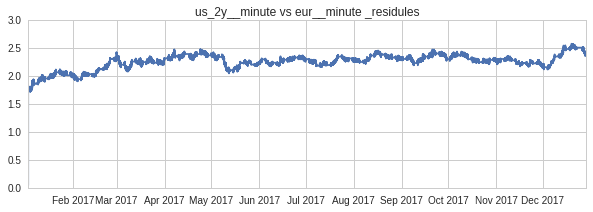

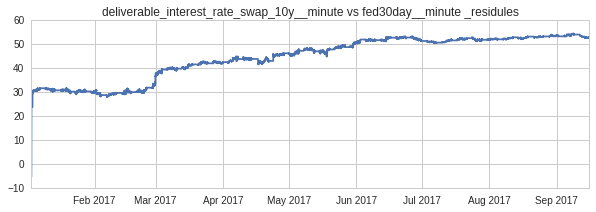

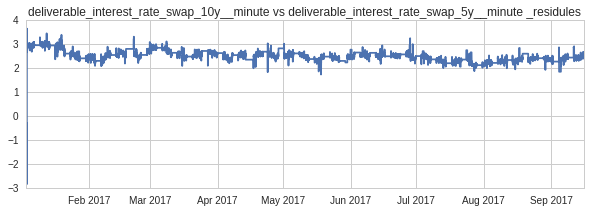

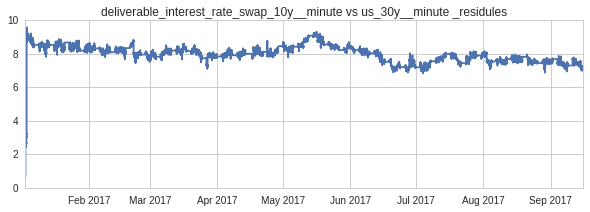

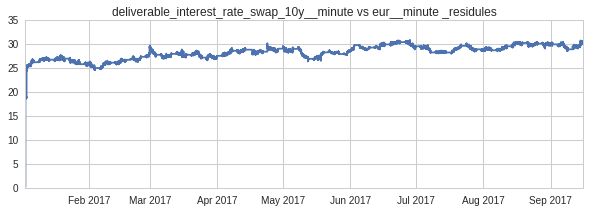

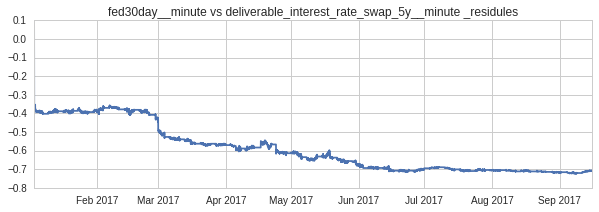

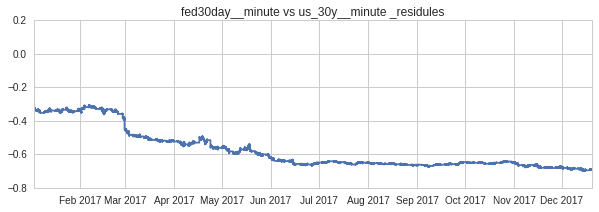

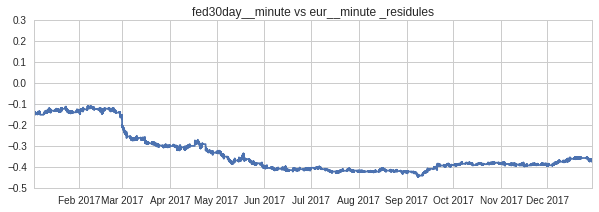

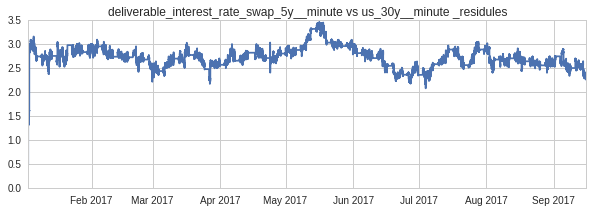

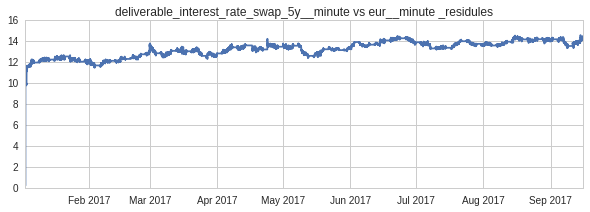

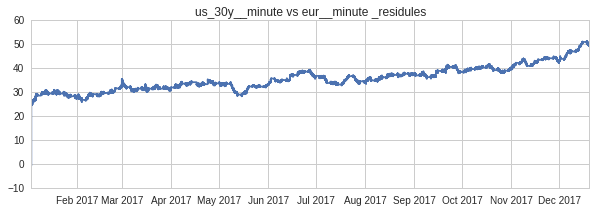

In [11]:
# Get ols parameters using in-sample data
ols_result = ols_in_sample(data,pairs)

# Get residules using validation data based on in-sample ols parameters
validation_data = get_data(Rates,start_date='2017-01-01', end_date='2017-12-31')
n=ols_validation(validation_data, ols_result,pairs)
plotting(n)